# DEA Coastlines raster generation <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts raster generation for DEA Coastlines:

* Load stack of all available Landsat 5, 7 and 8 satellite imagery for a location using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html)
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a 2 x 2 km grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites from 1988 to the present representing the coastline at approximately mean sea level

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [`deacoastlines_generation.py`](deacoastlines_generation.py) Python script.

**Compatability:**
```
module use /g/data/v10/public/modules/modulefiles
module load dea/20200713
pip install --user ruptures
pip install --user git+https://github.com/mattijn/topojson/
pip install --user --upgrade --extra-index-url="https://packages.dea.ga.gov.au" odc-algo
pip install --upgrade dask==2021.1.1
```
---

## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [ ]:
# pip install mock

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_generation as deacl_gen

import os
import sys
import datacube
import geopandas as gpd
import multiprocessing
import xarray as xr
from functools import partial
import odc.algo
import numpy as np
from datacube.storage.masking import make_mask
from datacube.utils.geometry import Geometry

dc = datacube.Datacube(app='DEA_CoastLines')

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='3gb')
display(client)


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Client Scheduler: tcp://127.0.0.1:44773 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


### Load supplementary data

In [34]:
study_area = 329
raster_version = 'v0.0.1'
vector_version = 'v0.0.1'

# Tide points are used to model tides across the extent of the satellite data
points_gdf = gpd.read_file('input_data/5km_points_africa_coastal.geojson')

# Albers grid cells used to process the analysis
gridcell_gdf = (gpd.read_file('input_data/32km_grid_africa_coastal.geojson')
                .to_crs(epsg=4326)
                .set_index('id')
                .loc[[study_area]])

## Loading data
### Create query


In [35]:
# Create query
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
query = {'geopolygon': geopoly.buffer(0.05),
         'time': ('1980', '2021'),  # 1999, 2020
         'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}}


### Load virtual product

In [36]:
# Load virtual product    
ds = deacl_gen.load_mndwi(dc, 
                          query, 
                          yaml_path='virtual_products_v1.0.0.yaml',
                          product_name='ls_mndwi')
ds

<xarray.Dataset>
Dimensions:        (time: 926, x: 1328, y: 1533)
Coordinates:
  * time           (time) datetime64[ns] 1984-04-12T10:23:56.663044 ... 2021-...
  * y              (y) float64 3.991e+06 3.99e+06 ... 3.945e+06 3.945e+06
  * x              (x) float64 2.726e+05 2.727e+05 ... 3.124e+05 3.124e+05
    spatial_ref    int32 32630
Data variables:
    pixel_quality  (time, y, x) uint16 dask.array<chunksize=(1, 1533, 1328), meta=np.ndarray>
    mndwi          (time, y, x) float32 dask.array<chunksize=(1, 1533, 1328), meta=np.ndarray>
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref

In [38]:
# Identify pixels that are either cloud, cloud shadow or nodata
nodata = make_mask(ds['pixel_quality'], nodata=True)
mask = (make_mask(ds['pixel_quality'], cloud='high_confidence') |
        make_mask(ds['pixel_quality'], cloud_shadow='high_confidence') | nodata)

### Clean cloud mask

In [39]:
# Rechunk if smallest chunk is less than 10
if ((len(ds.x) % 3000) <= 10) or ((len(ds.y) % 3000) <= 10):
    ds = ds.chunk({'x': 3200, 'y': 3200})

# Close mask to remove small holes in cloud, open mask to 
# remove narrow false positive cloud, then dilate
# mask2 = odc.algo.binary_closing(mask, 5)
mask_cleaned = odc.algo.mask_cleanup(mask, r=(20, 0))
ds = ds.where(~mask_cleaned & ~nodata)

# Add new mask as nodata pixels
# ds = odc.algo.erase_bad(ds, mask, nodata=np.nan)

In [27]:
# ds.mndwi.isel(time=5).plot(vmin=-0.5, vmax=0.5)

## Tidal modelling
### Model tides at point locations

/home/jovyan/Robbi/dea-coastlines/deacoastlines_generation.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_vals = subset_gdf.geometry.centroid.x
/home/jovyan/Robbi/dea-coastlines/deacoastlines_generation.py:214: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_vals = subset_gdf.geometry.centroid.y


<AxesSubplot:>

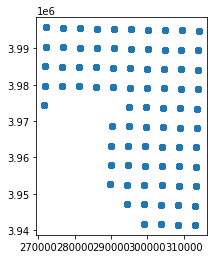

In [28]:
tidepoints_gdf = deacl_gen.model_tides(ds, points_gdf)
tidepoints_gdf.plot()

### Interpolate tides into each satellite timestep

In [ ]:
# test = [(group.x.values, group.y.values, group.time.values)
#  for (i, group) in ds.groupby('time')]

In [ ]:
# deacl_gen.interpolate_tide(tidepoints_gdf=tidepoints_gdf, timestep_tuple=test[10], factor=50).plot()

In [41]:
# Interpolate tides for each timestep into the spatial extent of the data 
out_list = [deacl_gen.interpolate_tide(tidepoints_gdf=tidepoints_gdf, 
                                       timestep_tuple=(group.x.values, group.y.values, group.time.values), 
                                       factor=50) 
                              for (i, group) in ds.groupby('time')]

# Combine to match the original dataset
ds['tide_m'] = xr.concat(out_list, dim=ds['time'])

In [ ]:
# pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
# print(f'Parallelising {multiprocessing.cpu_count() - 1} processes')
# out_list = pool.map(partial(deacl_gen.interpolate_tide,
#                             tidepoints_gdf=tidepoints_gdf,
#                             factor=50), 
#                     iterable=[(group.x.values, 
#                                group.y.values, 
#                                group.time.values) 
#                               for (i, group) in ds.groupby('time')])

# # Combine to match the original dataset
# ds['tide_m'] = xr.concat(out_list, dim=ds['time'])

<AxesSubplot:title={'center':'time = 1985-06-02T10:26:53.375050, spatial_ref ...'}, xlabel='x', ylabel='y'>

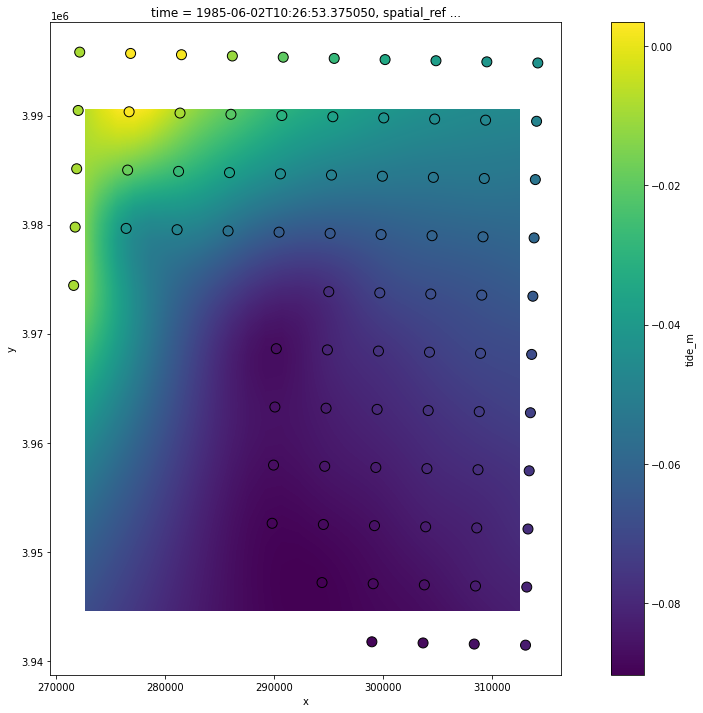

In [42]:
import matplotlib.pyplot as plt

# Plot 
ds_i = ds['tide_m'].isel(time=18).compute()
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(),
                                                     vmax=ds_i.max().item())


In [43]:
# Determine tide cutoff
tide_cutoff_buff = (
    (ds['tide_m'].max(dim='time') - ds['tide_m'].min(dim='time')) * 0.25)
tide_cutoff_min = 0.0 - tide_cutoff_buff  #.clip(1)
tide_cutoff_max = 0.0 + tide_cutoff_buff  #.clip(1)

## Generate yearly composites

In [44]:
import datetime  
start_time = datetime.datetime.now()

# If output folder doesn't exist, create it
output_dir = f'output_data/{study_area}_{raster_version}'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each year and export annual and 3-year gapfill composites
deacl_gen.export_annual_gapfill(ds, 
                                output_dir, 
                                tide_cutoff_min, 
                                tide_cutoff_max)

print(f'{(datetime.datetime.now() - start_time).seconds / 60:.1f} minutes')

Processing 1984
Processing 1985
Processing 1986
Processing 1987
Processing 1988
Processing 1989
Processing 1990
Processing 1991
Processing 1992
Processing 1993
Processing 1994
Processing 1995
Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
9.3 minutes


## Run from script

In [ ]:
# from deacoastlines_generation import main

# tiles = [376, 377, 379, 384, 385, 387, 388, 390, 392, 399]

# for tile in tiles:
#     print(tile)
#     main(['out', tile, 'v0.0.1', 'v0.0.1'])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** July 2021